In [93]:
import math
import pandas as pd
import numpy as np
import random
from scipy.interpolate import UnivariateSpline
from scipy.stats import rankdata
from scipy.special import logit as logit
from matplotlib import pyplot as plt

from cdlib import algorithms, viz
import community as community_louvain
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import k_clique_communities,label_propagation_communities, asyn_lpa_communities,greedy_modularity_communities
from networkx.algorithms.centrality import *
from networkx.algorithms.cluster import *
from networkx.algorithms.assortativity import *
# import igraph as ig

from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler 
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
 
from xgboost import XGBClassifier
import seaborn as sns
from Powerset import *

clinical_231_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\clinical_231_data.csv'
mRNA_231_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\data_mRNA_231_sort_with_sensitive.csv'
id_symbol_lookup_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\Hugo_Symbol_to_id.csv'
# filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\union_genes_4803.csv'

# Gene Network

In [2]:
def const_net(correlation, threshold):
    correlations = np.copy(correlation)
    for i in range(correlations.shape[0]):
        correlations[i][i]=0
    for i in range(correlations.shape[0]):
        for j in range(correlations.shape[0]):
            if correlations[i][j] < threshold and correlations[i][j]>-threshold:
                correlations[i][j]  = 0
            else:
                correlations[i][j]  = 1

    G = nx.Graph()
    G.add_nodes_from(np.arange(correlations.shape[0]))
    edge_list = []
    for i in range(correlations.shape[0]):
         for j in range(i+1, correlations.shape[0]):
                if correlations[i][j] == 1:
                    edge_list.append((i,j))

    print(len(edge_list))
    G.add_edges_from(edge_list)
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

### correlation distribution

23068809


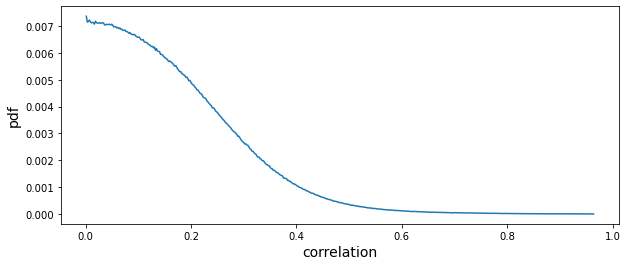

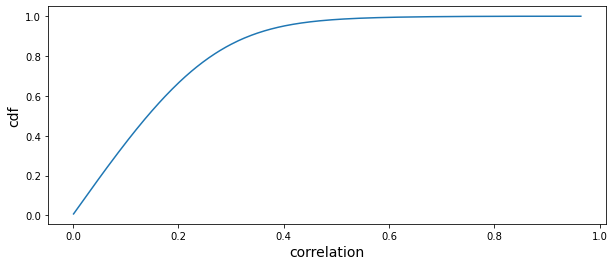

In [160]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]

for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0 :
            correlations[i][j]  = -correlations[i][j]
        
correlations = correlations.flatten()
print(len(correlations))

n = 500
s = np.asarray(correlations)   # generate your data sample with N elements
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
y = f(x)/len(correlations)

cdfy = np.cumsum(y)

plt.figure(figsize=(10,4))
plt.xlabel('correlation', fontsize=14)
plt.ylabel('pdf', fontsize=14)
plt.plot(x, y)
plt.show()


plt.figure(figsize=(10,4))
plt.xlabel('correlation', fontsize=14)
plt.ylabel('cdf', fontsize=14)
plt.plot(x, cdfy)
plt.show()

In [15]:
1-cdfy[350]



0.002408620228290803

### Net construct. Base on correaltion CDF. Set link threshold to 0.65 (avg node degree = 19.7) to 0.7 (avg node degree = 11.6)

In [ ]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]
print(correlations.shape)

link_thre = 0.65
for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < link_thre and correlations[i][j]>-link_thre:
            correlations[i][j]  = 0
        else:
            correlations[i][j]  = 1
#             nodes =  np.delete(nodes, np.where(nodes == i))
#             nodes =  np.delete(nodes, np.where(nodes == j))
print(correlations)

G = nx.Graph()
# nodes = np.setdiff1d( np.arange(4803),nodes)
# G.add_nodes_from(nodes)
G.add_nodes_from(np.arange(4803))

edge_list = []

for i in range(correlations.shape[0]):
     for j in range(i+1, correlations.shape[0]):
            if correlations[i][j] == 1:
                edge_list.append((i,j))

print(len(edge_list))
G.add_edges_from(edge_list)
G.remove_nodes_from(list(nx.isolates(G)))

print(G.number_of_nodes())
com = algorithms.demon(G, min_com_size=50, epsilon=0.25) # works

m = com.link_modularity()
print(m)

### Gene net threshold selection and community detection

In [ ]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]

coms = []
modularities = []
for thre in np.arange(0.65, 0.71, 0.01):
    print(thre)
    G = const_net(correlations, thre)
    print(G.number_of_nodes())
    com = algorithms.demon(G, min_com_size=50, epsilon=0.25) # works
    coms.append(com)
    m = com.link_modularity()
    print(m)
    modularities.append(m)
print(modularities)

In [ ]:
# com = coms[4]
# com.to_node_community_map()

# Decision Tree model

### prepare data

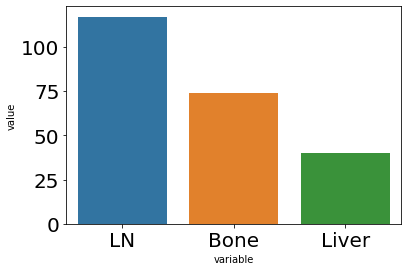

In [86]:
# with data balance
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
network_features = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv'

features_df = pd.read_csv(network_features)

def get_class_distribution(obj):
        count_dict = {
            "LN": 0,
            "Bone": 0,
            "Liver": 0
        } 
        for i in obj:
            if i == 0: 
                count_dict['LN'] += 1
            elif i == 1: 
                count_dict['Bone'] += 1
            elif i == 2: 
                count_dict['Liver'] += 1          
            else:
                print("Check classes.")          
        return count_dict
    
def data_preparation(filterd_data_path, data_balance=False):
    genes_df = pd.read_csv(filterd_data_path)
    df = genes_df.drop(columns = ['Hugo_ID'])
    
    if data_balance:
        pt_np = np.array(df.T)
        new_np = np.repeat(pt_np[:117],2, axis=0) 
        new_np = np.concatenate((new_np, np.repeat(pt_np[117:191],3, axis=0) ), axis=0)
        new_np = np.concatenate((new_np, np.repeat(pt_np[191:],6, axis=0) ), axis=0)
        df = pd.DataFrame(new_np)
        cancer_types =  [0]*117*2+[1]*74*3+[2]*40*6     
    else:   
        cancer_types =  [0]*117+[1]*74+[2]*40
        df = df.T
    df['cancer'] = cancer_types
#     print(df)

    class2idx = {
        0:0,
        1:1,
        2:2}
    idx2class = {v: k for k, v in class2idx.items()}
    df['cancer'].replace(class2idx, inplace=True)
    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1]
    
    ax = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y)]).melt(),\
                x = "variable", y="value")
    return X,y




X,y = data_preparation(filterd_data)
ori_X = X.copy(deep=True)

### X_Val and tail gene removal 

Loop 0
Accuracy: 92.61%
Accuracy: 90.91%
Accuracy: 93.08%
Accuracy: 91.76%
Accuracy: 92.23%
Accuracy: 92.17%
Accuracy: 91.81%
Accuracy: 92.68%
Accuracy: 92.64%
Accuracy: 93.12%
Accuracy: 92.19%
Accuracy: 91.32%
Accuracy: 92.23%
Accuracy: 92.23%
Accuracy: 91.38%
Accuracy: 93.08%
Accuracy: 92.66%
Accuracy: 92.21%
Accuracy: 92.64%
Accuracy: 92.68%
Accuracy: 93.50%
Accuracy: 91.36%
Accuracy: 92.21%
Accuracy: 92.23%
Accuracy: 93.06%
Accuracy: 92.21%
Accuracy: 92.64%
Accuracy: 92.70%
Accuracy: 92.61%
Accuracy: 92.64%
Accuracy: 93.06%
Accuracy: 92.17%
Accuracy: 91.76%
Accuracy: 93.95%
Accuracy: 92.17%
Accuracy: 92.63%
Accuracy: 92.19%
Accuracy: 91.32%
Accuracy: 93.06%
Accuracy: 91.34%
Accuracy: 92.63%
Accuracy: 92.23%
Accuracy: 92.21%
Accuracy: 91.76%
Accuracy: 92.19%
Accuracy: 93.50%
Accuracy: 91.79%
Accuracy: 90.92%
Accuracy: 91.76%
Accuracy: 93.06%
Accuracy: 91.76%
Accuracy: 90.49%
Accuracy: 92.63%
Accuracy: 91.36%
Accuracy: 92.63%
Accuracy: 92.19%
Accuracy: 93.51%
Accuracy: 91.36%
Accurac

Accuracy: 93.51%
Accuracy: 94.38%
Accuracy: 93.97%
Accuracy: 93.93%
Accuracy: 93.06%
Accuracy: 93.08%
Accuracy: 92.61%
Accuracy: 92.61%
Accuracy: 93.12%
Accuracy: 93.04%
Accuracy: 93.91%
Accuracy: 91.78%
Accuracy: 93.95%
Accuracy: 93.95%
Accuracy: 92.61%
Accuracy: 91.81%
Accuracy: 91.36%
Accuracy: 93.10%
Accuracy: 93.04%
Accuracy: 91.30%
Accuracy: 90.87%
Accuracy: 90.94%
Accuracy: 93.08%
Accuracy: 90.89%
Accuracy: 92.23%
Accuracy: 93.06%
Accuracy: 93.51%
Accuracy: 91.32%
Accuracy: 91.78%
Accuracy: 92.17%
Accuracy: 93.06%
Accuracy: 91.34%
Accuracy: 90.07%
Accuracy: 90.51%
Accuracy: 90.47%
Accuracy: 90.91%
Accuracy: 90.92%
Accuracy: 89.17%
Accuracy: 86.54%
Loop 4
Accuracy: 91.78%
Accuracy: 91.74%
Accuracy: 91.76%
Accuracy: 92.61%
Accuracy: 92.66%
Accuracy: 92.23%
Accuracy: 92.61%
Accuracy: 92.17%
Accuracy: 93.12%
Accuracy: 92.21%
Accuracy: 91.78%
Accuracy: 90.92%
Accuracy: 92.25%
Accuracy: 92.64%
Accuracy: 93.53%
Accuracy: 91.76%
Accuracy: 90.92%
Accuracy: 92.25%
Accuracy: 92.17%
Accurac

Accuracy: 92.66%
Accuracy: 92.66%
Accuracy: 92.19%
Accuracy: 91.36%
Accuracy: 93.10%
Accuracy: 92.25%
Accuracy: 91.74%
Accuracy: 93.04%
Accuracy: 92.21%
Accuracy: 92.23%
Accuracy: 91.79%
Accuracy: 92.25%
Accuracy: 93.08%
Accuracy: 92.61%
Accuracy: 92.64%
Accuracy: 93.08%
Accuracy: 91.76%
Accuracy: 92.23%
Accuracy: 91.36%
Accuracy: 92.61%
Accuracy: 93.08%
Accuracy: 93.53%
Accuracy: 92.17%
Accuracy: 92.63%
Accuracy: 93.06%
Accuracy: 92.61%
Accuracy: 90.47%
Accuracy: 93.50%
Accuracy: 92.19%
Accuracy: 94.37%
Accuracy: 94.40%
Accuracy: 93.51%
Accuracy: 91.78%
Accuracy: 94.37%
Accuracy: 93.51%
Accuracy: 93.93%
Accuracy: 91.78%
Accuracy: 93.91%
Accuracy: 93.08%
Accuracy: 92.26%
Accuracy: 93.15%
Accuracy: 93.06%
Accuracy: 94.38%
Accuracy: 93.93%
Accuracy: 92.21%
Accuracy: 94.40%
Accuracy: 93.06%
Accuracy: 93.53%
Accuracy: 93.53%
Accuracy: 93.04%
Accuracy: 92.21%
Accuracy: 92.63%
Accuracy: 93.53%
Accuracy: 91.74%
Accuracy: 91.36%
Accuracy: 91.32%
Accuracy: 91.78%
Accuracy: 91.36%
Accuracy: 93.5

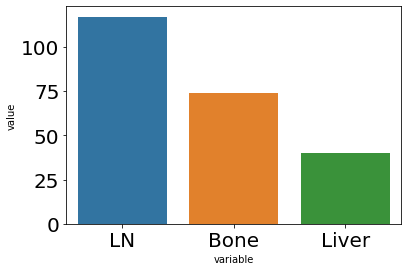

In [76]:
def drop_last_importance_gene(current_gene_X, drop_index):
    res_X = current_gene_X.drop(columns=[drop_index])
    return res_X

lp_acc = []
for lp in range(10):
    
    print("Loop "+str(lp))
    accs = []
    gene_taken_off_sequence = []
    
    X,y = data_preparation(filterd_data)
    
    model = XGBClassifier()
    model.fit(X, y)
    # get importance
    importance = model.feature_importances_
    trace_list = list(range(len(importance)))
    genes_df = pd.DataFrame({'index':trace_list,'importance':importance}) 
    # print(genes_df)
    genes_df = genes_df.sort_values(by='importance',axis=0,ascending=[False])
    sorted_index_by_importance = list(genes_df['index'])

    for i in range(130):
        last_important_gene_id = sorted_index_by_importance.pop(-1)
        gene_taken_off_sequence.append(last_important_gene_id)
        trace_list.remove(last_important_gene_id)
#         print(last_important_gene_id)
        X = drop_last_importance_gene(X, last_important_gene_id)
#         print(X.shape[1])
        model = XGBClassifier()
        kfold = KFold(n_splits=10,shuffle=True)
        results = cross_val_score(model, X, y, cv=kfold) # same data split for each loop
        print("Accuracy: %.2f%%" % (results.mean()*100))
        accs.append(results.mean())
        model = XGBClassifier()
        model.fit(X, y)
        # get importance
        importance = model.feature_importances_
        genes_df = pd.DataFrame({'index':trace_list,'importance':importance}) 
        genes_df = genes_df.sort_values(by='importance',axis=0,ascending=[False])
        sorted_index_by_importance = list(genes_df['index'])
    lp_acc.append(accs)

[0.92288043 0.9190942  0.9198913  0.92201087 0.92610507 0.92197464
 0.9211413  0.92076087 0.92052536 0.92072464 0.91820652 0.91896739
 0.91820652 0.92342391 0.92469203 0.92123188 0.92516304 0.91572464
 0.92367754 0.91824275 0.92266304 0.92030797 0.92121377 0.91476449
 0.92255435 0.92132246 0.9207971  0.91911232 0.92038043 0.92206522
 0.92043478 0.92240942 0.92166667 0.92641304 0.92630435 0.92378623
 0.91733696 0.91849638 0.92072464 0.92155797 0.92333333 0.9246558
 0.9245471  0.9195471  0.92414855 0.92376812 0.9242029  0.91905797
 0.92335145 0.92380435 0.91731884 0.91817029 0.92126812 0.92423913
 0.92467391 0.9226087  0.92461957 0.91853261 0.92206522 0.92643116
 0.92336957 0.92431159 0.92507246 0.92603261 0.9225     0.92686594
 0.92557971 0.93202899 0.92336957 0.92615942 0.92422101 0.92592391
 0.92601449 0.92688406 0.92559783 0.92478261 0.92460145 0.92807971
 0.92425725 0.92594203 0.92681159 0.93554348 0.9313587  0.93458333
 0.93117754 0.93331522 0.93237319 0.93289855 0.92907609 0.93588

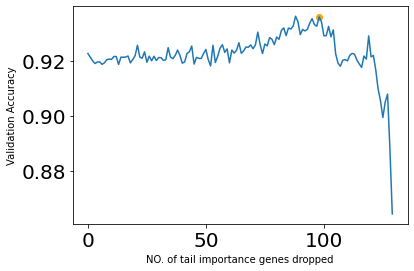

In [94]:
accs = np.mean(lp_acc,axis=0)
print(accs)
print(gene_taken_off_sequence)

plt.figure()
plt.xlabel('NO. of tail importance genes dropped')
plt.ylabel('Validation Accuracy')
plt.plot(np.arange(len(accs)), accs)
plt.scatter(98, accs[98], color = 'orange')
# plt.scatter(123, accs[123], color = 'y')
plt.show()
# drop_index = gene_taken_off_sequence[:-26] for good prediction. 
# drop_index = gene_taken_off_sequence[:-8] for testing patient net features

In [96]:
# accs = [0.92255435, 0.92121377, 0.91990036, 0.91893116, 0.91946558,
#        0.9195471 , 0.91861413, 0.91921196, 0.92032609, 0.92056159,
#        0.92042572, 0.92148551, 0.92145833, 0.91859601, 0.92125   ,
#        0.92118659, 0.92131341, 0.92163949, 0.91917572, 0.92036232,
#        0.9217663 , 0.92557971, 0.92125906, 0.92084239, 0.92317029,
#        0.91938406, 0.9215942 , 0.91993659, 0.92156703, 0.92001812,
#        0.92111413, 0.92105978, 0.92008152, 0.92029891, 0.92469203,
#        0.92125906, 0.92070652, 0.92188406, 0.92380435, 0.92184783,
#        0.91906703, 0.91951087, 0.92258152, 0.92318841, 0.92527174,
#        0.91873188, 0.92117754, 0.92080616, 0.9207337 , 0.92256341,
#        0.92401268, 0.92032609, 0.91806159, 0.92556159, 0.91929348,
#        0.92153986, 0.92447464, 0.92575181, 0.92298007, 0.92423007,
#        0.91918478, 0.92382246, 0.92269928, 0.92378623, 0.92645833,
#        0.92264493, 0.92351449, 0.92492754, 0.9248279 , 0.92567935,
#        0.92429348, 0.92572464, 0.93031703, 0.92576993, 0.92254529,
#        0.92601449, 0.92533514, 0.92833333, 0.92772645, 0.92576993,
#        0.92853261, 0.92771739, 0.93093297, 0.93185688, 0.92907609,
#        0.93181159, 0.93143116, 0.93251812, 0.93608152, 0.93416667,
#        0.92942029, 0.93131341, 0.93076087, 0.93133152, 0.93353261,
#        0.93520471, 0.93304348, 0.93245471, 0.93586159, 0.93400362,
#        0.92901268, 0.9290308 , 0.93237319, 0.92862319, 0.93113225,
#        0.92246377, 0.91908514, 0.91794384, 0.92012681, 0.92036232,
#        0.91990036, 0.92192935, 0.92259964, 0.92228261, 0.92018116,
#        0.91878623, 0.91750906, 0.92164855, 0.92053442, 0.92895833,
#        0.9213587 , 0.92184783, 0.91658514, 0.90961051, 0.90548007,
#        0.89933877, 0.90495471, 0.90782609, 0.88783514, 0.86438406]
# accs

0.9315217391304348
Accuracy: 92.64% (4.77%)
Accuracy: 94.38% (1.94%)
Accuracy: 93.53% (3.41%)
Accuracy: 93.93% (4.44%)
Accuracy: 91.74% (6.86%)
Accuracy: 92.63% (4.79%)
Accuracy: 93.95% (4.41%)
Accuracy: 93.93% (2.90%)
Accuracy: 94.38% (4.76%)
Accuracy: 92.23% (6.04%)
       0     1     2
0  113.5   2.1   1.4
1    6.8  67.2   0.0
2    4.2   1.3  34.5
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1170
           1       0.97      0.91      0.94       740
           2       0.96      0.87      0.91       400

    accuracy                           0.93      2310
   macro avg       0.94      0.92      0.93      2310
weighted avg       0.94      0.93      0.93      2310



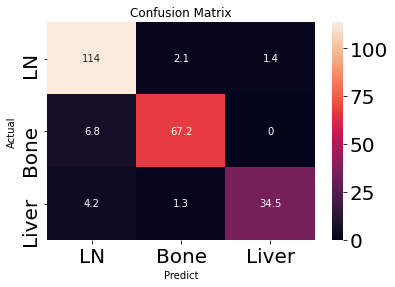

In [87]:

gene_taken_off_sequence = [41, 88, 95, 34, 81, 82, 65, 62, 100, 104, 115, 29, 113, 91, 37, 56, 116, 17, 18, 60, 102, 78, 122, 121, 73, 105, 50, 98, 45, 119, 92, 84, 14, 15, 130, 101, 128, 126, 125, 127, 51, 103, 124, 26, 59, 42, 77, 8, 6, 35, 111, 90, 19, 38, 97, 58, 112, 23, 55, 47, 72, 114, 89, 54, 106, 1, 117, 20, 25, 131, 9, 3, 108, 79, 43, 110, 86, 39, 5, 24, 52, 30, 109, 53, 10, 87, 27, 132, 67, 44, 94, 75, 49, 13, 76, 74, 40, 46, 63, 68, 123, 12, 31, 33, 71, 118, 93, 4, 80, 96, 83, 85, 129, 0, 16, 107, 99, 61, 70, 57, 64, 69, 7, 28, 2, 66, 36, 120, 21, 22]
len(gene_taken_off_sequence)
features_df = pd.read_csv(network_features)
print(accs[-32])
drop_index = gene_taken_off_sequence[:-31]

X = ori_X.drop(columns=drop_index)


model = XGBClassifier()
# kfold = KFold(n_splits=10,shuffle=True)

kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
y_pred = list(cross_val_predict(model, X, y, cv=kfold))
conf_mat = confusion_matrix(y, y_pred)
# print(conf_mat)

for i in range(9):
    model = XGBClassifier()
    # kfold = KFold(n_splits=10,shuffle=True)

    kfold = KFold(n_splits=10,shuffle=True)
    results = cross_val_score(model, X, y, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    y_pred += list(cross_val_predict(model, X, y, cv=kfold))
#     y_pred+=y_pred
#     print(conf_mat)

y = list(y)*10
conf_mat = confusion_matrix(y, y_pred)/10

class2idx = {
    'LN':0,
    'Bone':1,
    'Liver':2
}

idx2class = {v: k for k, v in class2idx.items()}
# print(idx2class)
print(pd.DataFrame(mat))
confusion_matrix_df = pd.DataFrame(mat).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True, fmt=".3g").set(xlabel="Predict", ylabel = "Actual",title="Confusion Matrix")
print(classification_report(y, y_pred))

In [83]:
len(y_pred)

462

# Patient network

### Patient network construction: 
Based on results above, only keep the most 29 important genes.

In [22]:
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
network_features = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv'

gene_taken_off_sequence = [41, 88, 95, 34, 81, 82, 65, 62, 100, 104, 115, 29, 113, 91, 37, 56, 116, 17, 18, 60, 102, 78, 122, 121, 73, 105, 50, 98, 45, 119, 92, 84, 14, 15, 130, 101, 128, 126, 125, 127, 51, 103, 124, 26, 59, 42, 77, 8, 6, 35, 111, 90, 19, 38, 97, 58, 112, 23, 55, 47, 72, 114, 89, 54, 106, 1, 117, 20, 25, 131, 9, 3, 108, 79, 43, 110, 86, 39, 5, 24, 52, 30, 109, 53, 10, 87, 27, 132, 67, 44, 94, 75, 49, 13, 76, 74, 40, 46, 63, 68, 123, 12, 31, 33, 71, 118, 93, 4, 80, 96, 83, 85, 129, 0, 16, 107, 99, 61, 70, 57, 64, 69, 7, 28, 2, 66, 36, 120, 21, 22]
len(gene_taken_off_sequence)
features_df = pd.read_csv(network_features)
print(accs[-32])
drop_index = gene_taken_off_sequence[:-31]

X = ori_X.drop(columns=drop_index)

df = X
df


0.9380615942028985


,0,2,4,7,11,12,16,21,22,28,...,83,85,93,96,99,107,118,120,123,129
0,8.693,0.243,3.038,2.725,0.113,8.700,0.740,0.670,4.526,0.044,...,0.191,0.282,0.015,0.394,0.033,0.004,0.439,0.065,0.035,0.027
1,22.395,0.392,0.185,12.568,0.510,20.315,0.603,8.116,27.136,0.000,...,3.517,0.372,0.225,1.541,0.000,0.092,0.464,0.043,0.372,0.053
2,50.843,0.418,0.295,0.812,0.378,15.705,2.218,2.037,17.231,0.000,...,2.142,0.442,0.000,1.135,0.115,0.053,0.595,0.009,0.118,0.028
3,66.151,332.090,1.566,5.638,0.364,70.434,3.301,3.954,9.239,0.005,...,11.055,1.126,7.147,18.510,0.072,3.027,1.837,0.018,0.673,0.134
4,54.679,0.367,0.492,0.439,0.098,10.262,0.748,0.979,28.286,0.008,...,0.317,0.657,0.105,1.353,0.048,0.046,0.352,0.058,0.203,0.243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,78.057,0.542,0.194,0.791,63.541,9.961,0.224,26.979,3.057,0.061,...,3.598,0.599,0.692,0.882,0.028,0.500,0.051,0.009,0.084,0.027
227,307.665,0.274,0.661,3.500,212.318,7.213,0.152,120.603,0.889,0.000,...,1.816,0.950,1.161,1.273,0.023,1.364,0.016,0.008,0.390,0.006
228,224.079,0.853,0.000,6.981,0.391,13.284,0.016,4.868,2.877,0.027,...,2.639,0.100,0.130,0.303,0.017,0.055,0.032,0.000,1.100,0.016
229,8.973,0.891,0.044,0.463,25.003,13.021,0.000,19.098,1.502,0.000,...,1.860,0.755,3.365,0.615,0.000,0.440,0.042,0.003,0.525,0.091


133

### Patient network link(correlation) distribution

[[0.41046525 0.3850113  0.02041084 ... 0.203832   0.08406012 0.16396054]
 [0.41046525 0.76287909 0.09973595 ... 0.51713121 0.09519093 0.23629668]
 [0.3850113  0.76287909 0.15080034 ... 0.90817067 0.0986961  0.62095317]
 ...
 [0.203832   0.51713121 0.90817067 ... 0.76835378 0.10618919 0.60018536]
 [0.08406012 0.09519093 0.0986961  ... 0.40809361 0.10618919 0.18703301]
 [0.16396054 0.23629668 0.62095317 ... 0.50170928 0.60018536 0.18703301]]
53130


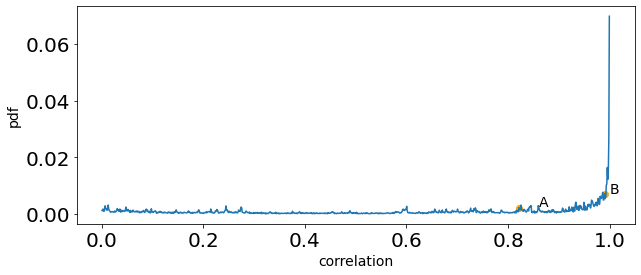

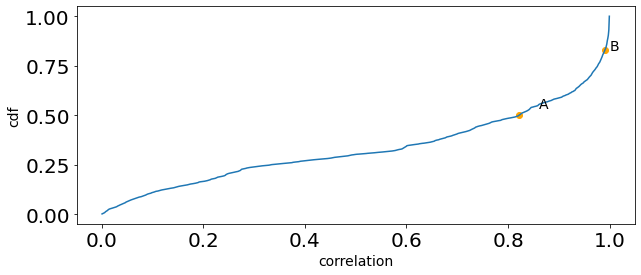

correlation threshold to median:  0.8215008462598562 CDF 0.4994515835445561
correlation threshold to 0.99:  0.9905000335396179 CDF 0.8276667494804996


In [31]:
X = ori_X.drop(columns=drop_index)

correlations = np.corrcoef(X, X)[:231, :231]

for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 

correlations = correlations[~np.eye(correlations.shape[0],dtype=bool)].reshape(correlations.shape[0],-1)# remove diagnal
print(correlations)
correlations = correlations.flatten()
print(len(correlations))


n = 1000
s = np.asarray(correlations)   # generate your data sample with N elements
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
y = f(x)/len(correlations)

cdfy = np.cumsum(y)

plt.figure(figsize=(10,4))
plt.xlabel('correlation', fontsize=14)
plt.ylabel('pdf', fontsize=14)
plt.plot(x, y)
plt.scatter(x[821], y[821], color = 'orange')
plt.scatter(x[990], y[990], color = 'orange')
plt.text(0.86, y[844], 'A', fontsize=14)
plt.text(1, y[990], 'B', fontsize=14)
plt.show()


plt.figure(figsize=(10,4))
plt.xlabel('correlation', fontsize=14)
plt.ylabel('cdf', fontsize=14)
plt.plot(x, cdfy)
plt.scatter(x[821], cdfy[821], color = 'orange')
plt.scatter(x[990], cdfy[990], color = 'orange')
plt.text(0.86, cdfy[844], 'A', fontsize=14)
plt.text(1, cdfy[990], 'B', fontsize=14)
plt.show()

print('correlation threshold to median: ',x[821], 'CDF', cdfy[821])
print('correlation threshold to 0.99: ',x[990], 'CDF', cdfy[990])

In [32]:
a = 821
print(x[a], cdfy[a]) #0.8215008462598562 0.4994515835445561

0.8215008462598562 0.4994515835445561


### Weighted Patient Net construction. 


In [33]:
df = X

correlations = np.corrcoef(df, df)[:231, :231]
for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 
            
ex_df = pd.DataFrame(correlations)

G = nx.Graph()
G.add_nodes_from(np.arange(231))

for i in range(correlations.shape[0]):
    for j in range(i+1,correlations.shape[0]):
        G.add_edge(i, j, weight=correlations[i][j])
#         print(correlations[i][j])



patient_net_features_df = pd.DataFrame()
de = G.degree(weight='weight')
cc = nx.clustering(G,weight='weight')

patient_net_features_df['weighted_degree'] = np.array(de).T[1][:]
patient_net_features_df['weighted_clustering_coef'] = cc.values()
patient_net_features_df

# # Community detection on weighted network
# # com = algorithms.louvain(G,weight='weight')
# com = algorithms.greedy_modularity(G,weight='weight')
# # com = algorithms.agdl(G,number_communities=3, kc=4)
# com.to_node_community_map()

# clusters = com.to_node_community_map()

# com_list = np.array(list(clusters.values())).flatten()
# com_num = max(com_list)+1
# node_list = list(clusters.keys())
# print(com_num)
# LN_p = [0]*com_num
# Bone_p = [0]*com_num
# Liver_p = [0]*com_num

# for i in range(len(com_list)):
#     node_No = node_list[i]
#     com_NO = com_list[i]
# #     print(com_NO)
#     if node_No <117:
#         LN_p[com_NO]+=1
#     elif node_No >= 117 and node_No <191:
#         Bone_p[com_NO]+=1
#     else:
#         Liver_p[com_NO]+=1
        
# print(sum(LN_p),sum(Bone_p),sum(Liver_p))
# patient_com_df = pd.DataFrame()
# patient_com_df['LN'] = LN_p
# patient_com_df['Bone'] = Bone_p
# patient_com_df['Liver'] = Liver_p
# patient_com_df

,weighted_degree,weighted_clustering_coef
0,62.992682,0.321438
1,121.196914,0.535501
2,178.406144,0.701293
3,30.329970,0.210921
4,172.601892,0.684986
...,...,...
226,143.621580,0.599854
227,147.431694,0.606369
228,184.056375,0.710395
229,30.535825,0.185185


In [124]:
# com.newman_girvan_modularity() #louvain 4 coms score=0.03997515260593122. greedy_modularity
# com.z_modularity() #louvain score=-0.005028898200744024. greedy_modularity

### Convert to unweighted graph. 
Base on above observation, set threshold to 0.99.

In [166]:
# For gephi
cores = np.copy(correlations)
print(correlations)
link_thres = 0.99

link_num = 0
for i in range(cores.shape[0]):
    for j in range(cores.shape[1]):
        if cores[i,j] > link_thres:
            cores[i,j] = 1
            link_num+=1
        else:
            cores[i,j] = 0
print("Number of links: ", link_num)
print("Avg. Node Degree: ", link_num/231)

temp_df = pd.DataFrame(cores)
temp_df
# temp_df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv")

[[0.         0.37303578 0.35734508 ... 0.20049282 0.04776391 0.16135619]
 [0.37303578 0.         0.75278361 ... 0.55661845 0.0045716  0.25935519]
 [0.35734508 0.75278361 0.         ... 0.92724776 0.04616677 0.64131612]
 ...
 [0.20049282 0.55661845 0.92724776 ... 0.         0.09336545 0.60120337]
 [0.04776391 0.0045716  0.04616677 ... 0.09336545 0.         0.17928695]
 [0.16135619 0.25935519 0.64131612 ... 0.60120337 0.17928695 0.        ]]
Number of links:  11608
Avg. Node Degree:  50.25108225108225


,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,225,226,227,228,229,230
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
228,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
np.median(correlations)

0.8212544234879704

Number of links:  13224
Avg. Node Degree:  114.49350649350649
     weighted_degree  weighted_clustering_coef  degree  clustering_coef  \
0          62.992682                  0.321438      10         0.755556   
1         121.196914                  0.535501      11         0.636364   
2         178.406144                  0.701293     167         0.865955   
3          30.329970                  0.210921       0         0.000000   
4         172.601892                  0.684986     161         0.885404   
..               ...                       ...     ...              ...   
226       143.621580                  0.599854      10         0.600000   
227       147.431694                  0.606369       9         0.833333   
228       184.056375                  0.710395     161         0.966770   
229        30.535825                  0.185185       0         0.000000   
230       111.503624                  0.508598       0         0.000000   

     average_neighbor_degree  
0     

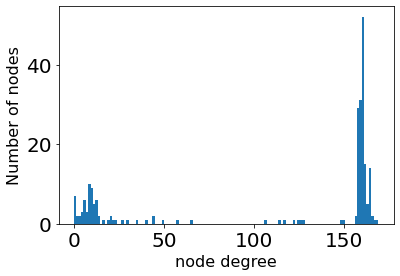

In [54]:
X = ori_X.drop(columns=drop_index)

correlations = np.corrcoef(X, X)[:231, :231]

# link_thres = 0.99
link_thres = np.median(correlations)

G = nx.Graph()
G.add_nodes_from(np.arange(231))
# G.nodes()
link_num = 0
for i in range(correlations.shape[0]):
    for j in range(i+1,correlations.shape[0]):
        if correlations[i,j] > link_thres:
            G.add_edge(i, j)
            link_num+=1
print("Number of links: ", link_num)
print("Avg. Node Degree: ", link_num*2/231)

de = G.degree()
cc = nx.clustering(G)
patient_net_features_df['degree'] = np.array(de).T[1][:]
patient_net_features_df['clustering_coef'] = cc.values()
patient_net_features_df['average_neighbor_degree'] = average_neighbor_degree(G).values()
# Add code to calculate Avg. Neighbour degree
average_neighbor_degree(G)
# End of code

patient_net_features_df.round(3)
print(patient_net_features_df)

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees,bins=128)
    plt.xlabel('node degree',fontsize = 16)
    plt.ylabel('Number of nodes',fontsize = 16)
    plt.show()

plot_degree_dist(G)

In [41]:
degrees = [G.degree(n) for n in G.nodes()]
sum(degrees)

15376

### Patient Network Community Detection (unweighted, non-overlapping)
Noticed large number of isolated nodes.

In [51]:
# com = algorithms.louvain(G)
print('Num of isolated nodes', len(list(nx.isolates(G))) )
G.remove_nodes_from(list(nx.isolates(G)))

com = algorithms.greedy_modularity(G)
# com = algorithms.agdl(G,number_communities=3, kc=4)
com.to_node_community_map()

Num of isolated nodes 74


defaultdict(list,
            {5: [0],
             9: [0],
             15: [0],
             17: [0],
             18: [0],
             22: [0],
             23: [0],
             26: [0],
             29: [0],
             30: [0],
             31: [0],
             34: [0],
             35: [0],
             36: [0],
             44: [0],
             50: [0],
             51: [0],
             64: [0],
             66: [0],
             67: [0],
             69: [0],
             70: [0],
             71: [0],
             74: [0],
             84: [0],
             85: [0],
             87: [0],
             93: [0],
             102: [0],
             119: [0],
             120: [0],
             125: [0],
             126: [0],
             127: [0],
             128: [0],
             129: [0],
             130: [0],
             131: [0],
             132: [0],
             133: [0],
             134: [0],
             136: [0],
             137: [0],
             139: [0],


In [52]:
clusters = com.to_node_community_map()

com_list = np.array(list(clusters.values())).flatten()
com_num = max(com_list)+1
node_list = list(clusters.keys())
print(com_num)
LN_p = [0]*com_num
Bone_p = [0]*com_num
Liver_p = [0]*com_num

for i in range(len(com_list)):
    node_No = node_list[i]
    com_NO = com_list[i]
#     print(com_NO)
    if node_No <117:
        LN_p[com_NO]+=1
    elif node_No >= 117 and node_No <191:
        Bone_p[com_NO]+=1
    else:
        Liver_p[com_NO]+=1
        
print(sum(LN_p),sum(Bone_p),sum(Liver_p))
patient_com_df = pd.DataFrame()
patient_com_df['LN'] = LN_p
patient_com_df['Bone'] = Bone_p
patient_com_df['Liver'] = Liver_p
patient_com_df

14
82 65 10


,LN,Bone,Liver
0,29,48,3
1,34,4,3
2,9,0,0
3,0,5,0
4,3,0,0
5,0,3,0
6,2,0,0
7,2,0,0
8,2,0,0
9,1,1,0


FitnessResult(min=None, max=None, score=0.06607899773476758, std=None)


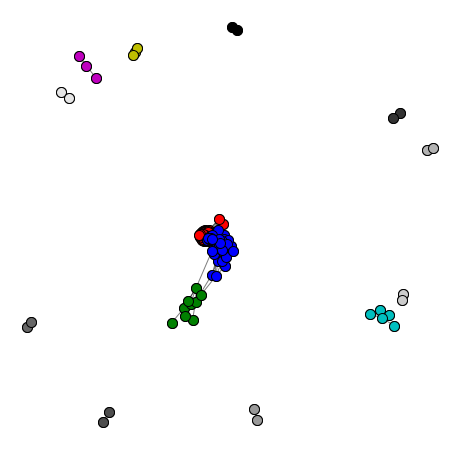

In [53]:
print(com.newman_girvan_modularity())
# com.z_modularity()
viz.plot_network_clusters(G, com, node_size = 100)